# Model performance

After training all SVMs, we assess model performance using precision and recall of both outcome classes.

### Importing packages

In [1]:
import numpy as np
import pandas as pd 
import pickle
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
#import matplotlib as mpl

### Functions to read files created by 2_modeltraining.py and to plot results

In [25]:
def pretty_results(filenames, filepath='../results/models/'):
    reslist = []
    for index1, filename in enumerate(filenames):
        res = pd.read_pickle(filepath+filename+'.pkl')
        for index2, cr in enumerate(res):
            trainval = ['train', 'val'][index2 % 2]
            sex = ['M', 'M', 'F', 'F'][index2 % 4]
            reslist.append([index1+1, trainval, sex, cr['0']['precision'], cr['0']['recall'], cr['0']['support'],
                            cr['1']['precision'], cr['1']['recall'], cr['1']['support']])
    res = pd.DataFrame(reslist).set_axis(['nback', 'trainval', 'sex', 'ok_precision', 'ok_recall', 'ok_support',
                                          'low_precision', 'low_recall', 'low_support'], axis=1)
    return(res)
    
def get_scores(res_df):
    res_df['old_defrate'] = res_df['low_support'] / (res_df['low_support'] + res_df['ok_support'])
    res_df['new_defrate'] = 1 - res_df['ok_precision']
    res_df['missed_dons'] = 1 - res_df['ok_recall']
    res_df['prevented_defs'] = res_df['low_recall']
    res_df['missed_per_prev'] = (res_df['ok_support'] - res_df['ok_recall'] * res_df['ok_support']) / (res_df['low_support'] - (1 - res_df['ok_precision']) * res_df['ok_support'])
    
    res_df['old_def_n'] = res_df['low_support']
    res_df['new_def_n'] = round((1 - res_df['ok_precision']) * res_df['ok_support'])
    res_df['old_don_n'] = res_df['ok_support']
    res_df['new_don_n'] = res_df['ok_recall'] * res_df['ok_support']
    
    return(res_df)
 
def plot_precision_recall(res_df, measure, ylim, ylab, save=False):
    pl_df = res_df.groupby(['sex', 'trainval'])

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    for name, group in pl_df:
        y = 0 if name[0] == 'F' else 1
        off = -0.2 if name[1] == 'train' else 0.2
        hatch = '/' if name[1] == 'val' else ''
        ax[y].bar(group.nback + off, group[measure], label=name[1], width=0.4, edgecolor='black', hatch=hatch)
        ax[y].set_ylim(ylim)
        ax[y].set_xticks(group.nback)
        ax[y].set_xticklabels(['SVM-1','SVM-2','SVM-3','SVM-4','SVM-5'], size='large')
        ax[y].set_ylabel(ylab, size='large')
    
    legloc = 'upper right' if measure == 'low_precision' else 'lower right'
    legbox = (1, 1) if measure == 'low_precision' else (1, 0)
    ax[0].legend(labels=['train', 'test'], bbox_to_anchor=legbox, loc=legloc, title='Dataset')
    ax[1].legend(labels=['train', 'test'], bbox_to_anchor=legbox, loc=legloc, title='Dataset')
    
    ax[0].set_title('Women')
    ax[1].set_title('Men')

    fig.tight_layout()
    plt.set_cmap('tab20')
    
    if save:
        path = '../results/plots_performance/'
        plt.savefig(path+save+'.png')
    
    plt.show()
    
def plot_precision_recall_comp(res_df, measure, ylim, ylab, save=False):
    pl_df = res_df.loc[res_df['trainval'] == 'val'].groupby(['sex', 'vars'])

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    for name, group in pl_df:
        y = 0 if name[0] == 'F' else 1
        off = -0.2 if name[1] == 'all' else 0.2
        hatch = '/' if name[1] == 'all' else ''
        colr = 'deepskyblue' if name[1] == 'all' else 'rebeccapurple'
        ax[y].bar(group.nback + off, group[measure], label=name[1], width=0.4, edgecolor='black', 
                  hatch=hatch, color=colr)
        ax[y].set_ylim(ylim)
        ax[y].set_xticks(group.nback)
        ax[y].set_xticklabels(['SVM-1','SVM-2','SVM-3','SVM-4','SVM-5'], size='large')
        ax[y].set_ylabel(ylab, size='large')

    legloc = 'upper right' if measure == 'low_precision' else 'lower right'
    legbox = (1, 1) if measure == 'low_precision' else (1, 0)
    ax[0].legend(labels=['all', 'only Hb'], bbox_to_anchor=legbox, loc=legloc, title='Predictor\nvariables')
    ax[1].legend(labels=['all', 'only Hb'], bbox_to_anchor=legbox, loc=legloc, title='Predictor\nvariables')
    
    ax[0].set_title('Women')
    ax[1].set_title('Men')

    fig.tight_layout()
    
    if save:
        path = '../results/plots_performance/'
        plt.savefig(path+save+'.png')
    
    plt.show()

# Model performance of SVM using all predictor variables
## Precision and recall plots for both outcome classes
Note the zoomed-in y-axes for precision plots in order to see differences between models more clearly.

In [3]:
res_df = pretty_results(['res_1', 'res_2', 'res_3', 'res_4', 'res_5'], filepath='../results/models/')
res_df = get_scores(res_df)

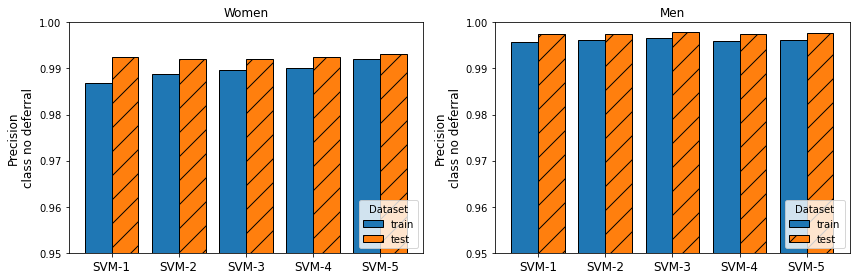

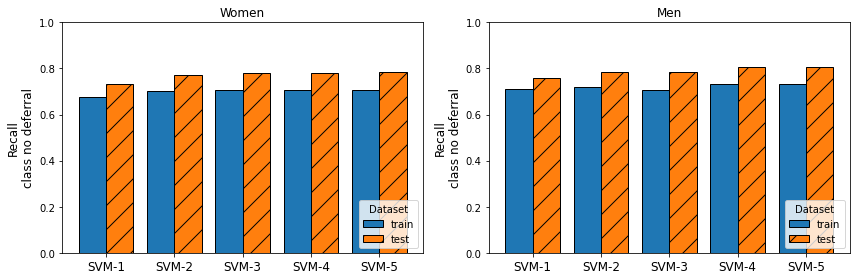

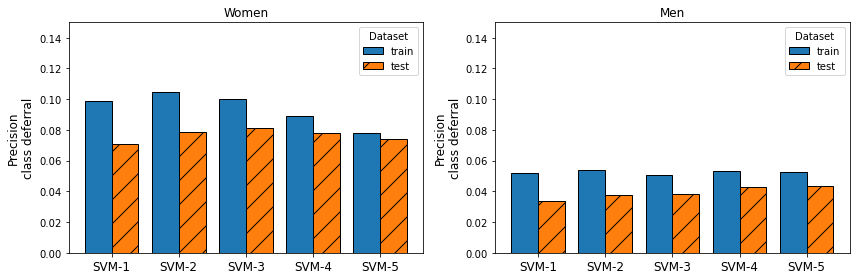

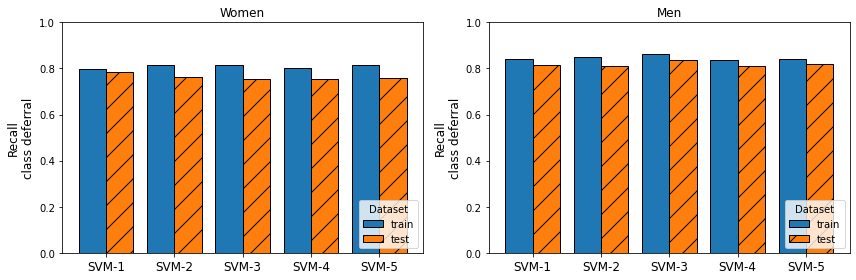

In [29]:
plot_precision_recall(res_df, 'ok_precision', (0.95, 1), 'Precision\nclass no deferral', save='all_ok_precision')
plot_precision_recall(res_df, 'ok_recall', (0, 1), 'Recall\nclass no deferral', save='all_ok_recall')
plot_precision_recall(res_df, 'low_precision', (0, 0.15), 'Precision\nclass deferral', 'all_low_precision')
plot_precision_recall(res_df, 'low_recall', (0, 1), 'Recall\nclass deferral', save='all_low_recall')

## Precision-recall curve
The PR curve shows the precision and recall at different probability thresholds for classification. This is more informative than a ROC curve because of the imbalanced outcome classes. A perfect classifier would have a precision of 1 for every recall value, so would look like a horizontal line at y=1. The area under the PR curve (AUPR) is a performance metric between 0 and 1 that indicates the quality of the classifier.  

### Functions to load probabilities and plot PR curves

In [32]:
def load_probas(sexes = ['men', 'women'], path = '../results/probas/proba_', nbacks = range(1, 6)):
    dfs = []
    for sex in sexes:
        for nback in nbacks:
            df = pd.read_pickle(path + sex + '_' + str(nback) + '.pkl')
            df['sex'] = sex
            df['nback'] = nback
            dfs.append(df)
    fulldf = pd.concat(dfs)
    return(fulldf)

def plot_prs(probas, save=False):
    fig, ax = plt.subplots(2, 2, figsize=(10,10))
    
    for x, sex in enumerate(['men', 'women']):
        df = probas.loc[probas['sex'] == sex, ]
        
        for key, group in df.groupby('nback'):
            precision_0, recall_0, thresholds_0 = precision_recall_curve(group.Hb_deferral, group.prob_low, pos_label=0)
            precision_1, recall_1, thresholds_1 = precision_recall_curve(group.Hb_deferral, group.prob_ok, pos_label=1)
            
            aupr_0 = round(average_precision_score(group.Hb_deferral, group.prob_low, pos_label=0), 3)
            aupr_1 = round(average_precision_score(group.Hb_deferral, group.prob_ok, pos_label=1), 3)

            ax[1,x].plot(recall_0, precision_0, label='SVM-'+str(key)+', AUPR: '+str(aupr_0))
            ax[0,x].plot(recall_1, precision_1, label='SVM-'+str(key)+', AUPR: '+str(aupr_1))
        
        ax[0,x].set_title('PR-curve class deferral - ' + ['men', 'women'][x])
        ax[0,x].set_xlabel('Recall')
        ax[0,x].set_ylabel('Precision')
        ax[1,x].set_title('PR-curve class no deferral - ' + ['men', 'women'][x])
        ax[1,x].set_xlabel('Recall')
        ax[1,x].set_ylabel('Precision')
        ax[0,x].legend(loc='upper right')
        ax[1,x].legend(loc='lower left')
        ax[0,x].set_ylim(0,0.5)
    
    #horizontal lines for baseline
    ax[0,0].hlines(y=def_m, xmin=0, xmax=1, color='grey', ls='--')
    ax[1,0].hlines(y=1-def_m, xmin=0, xmax=1, color='grey', ls='--')
    ax[0,1].hlines(y=def_f, xmin=0, xmax=1, color='grey', ls='--')
    ax[1,1].hlines(y=1-def_f, xmin=0, xmax=1, color='grey', ls='--')
    
    if save:
        path = '../results/plots_performance/'
        plt.savefig(path+save+'.png')
    
    plt.show()

First, predictions are made on the test set again, now storing the probability of each observation belonging to each outcome class. We also calculate the proportion of observations belonging to each class (true outcome), as these are the baseline values for the AUPR (the AUPR obtained by a classifier predicting only the majority class).

In [33]:
for nback in range(1,6):
    file_clf = '../results/models/clf_' + str(nback) + '.sav'
    clfs = pickle.load(open(file_clf, 'rb'))
    for index, sex in enumerate(['men', 'women']):
        #print(datetime.datetime.now(), 'Starting', nback, sex)
        clf = clfs[index]
        test = pd.read_pickle('../../data/scaled/'+str(sex)+'_'+str(nback)+'_test.pkl') 
        y_true = test[test.columns[-1:]].copy()
        y_pred = clf.predict_proba(test[test.columns[:-1]])
        y_true[['prob_low', 'prob_ok']] = y_pred
        file_preds = '../results/probas/proba_' + sex + '_' + str(nback) + '.pkl'
        pickle.dump(y_true, open(file_preds, 'wb'))
        
proba_m = pd.read_pickle('../results/probas/proba_men_1.pkl')
proba_f = pd.read_pickle('../results/probas/proba_women_1.pkl')
def_m = np.mean(proba_m.Hb_deferral)
def_f = np.mean(proba_f.Hb_deferral)

### PR curve 
PR curves for men and women, shown for each of the 5 SVMs. AUPR values are given in the legend. The grey dashed line indicates the baseline.

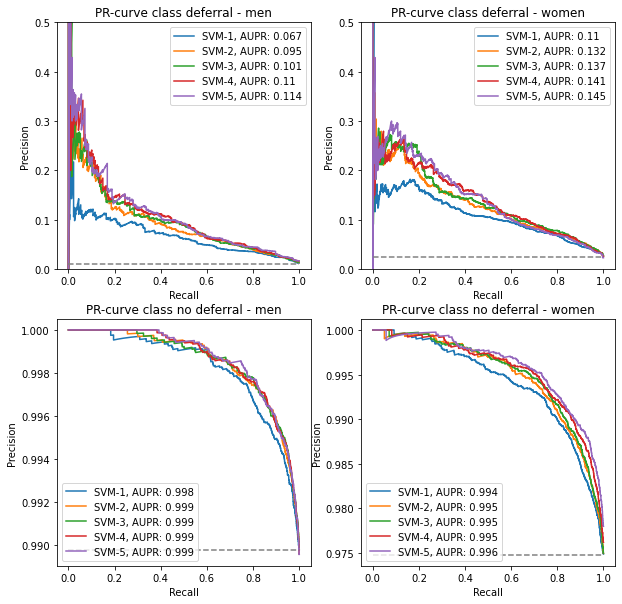

In [34]:
probas = load_probas()
plot_prs(probas, save='PR_curve')

# Model performance of SVM using only Hb variables

In [ ]:
res_df_onlyhb = pretty_results(['res_1', 'res_2', 'res_3', 'res_4', 'res_5'], filepath='../results/models_onlyhb/')
res_df_onlyhb = get_scores(res_df_onlyhb)

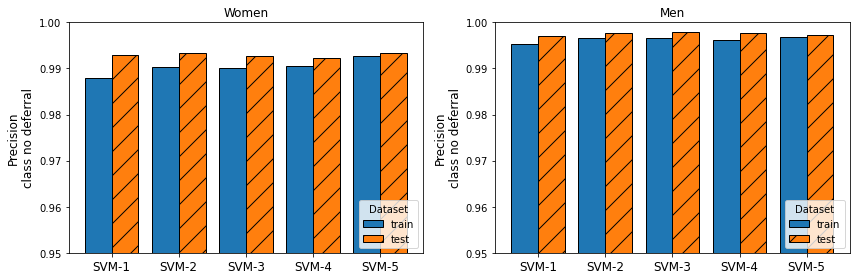

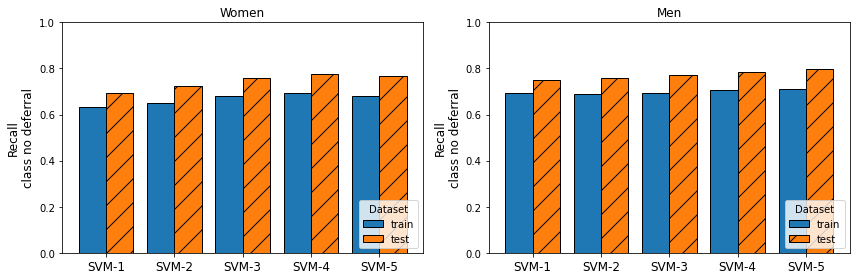

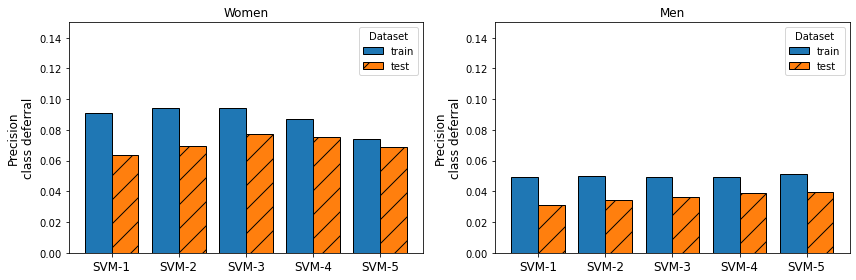

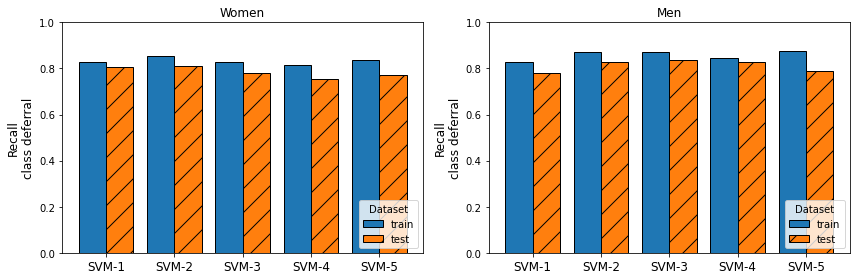

In [30]:
plot_precision_recall(res_df_onlyhb, 'ok_precision', (0.95, 1), 'Precision\nclass no deferral', save='onlyhb_ok_precision')
plot_precision_recall(res_df_onlyhb, 'ok_recall', (0, 1), 'Recall\nclass no deferral', save='onlyhb_ok_recall')
plot_precision_recall(res_df_onlyhb, 'low_precision', (0, 0.15), 'Precision\nclass deferral', save='onlyhb_low_precision')
plot_precision_recall(res_df_onlyhb, 'low_recall', (0, 1), 'Recall\nclass deferral', save='onlyhb_low_recall')

# Comparing performance between all vars and only Hb vars
Showing only the performance on the test set

## Graphical comparison of precision and recall

In [9]:
res_df['vars'] = 'all'
res_df_onlyhb['vars'] = 'onlyhb'

res_tot = pd.concat([res_df, res_df_onlyhb])
res_tot.head()

,nback,trainval,sex,ok_precision,ok_recall,ok_support,low_precision,low_recall,low_support,old_defrate,new_defrate,missed_dons,prevented_defs,missed_per_prev,old_def_n,new_def_n,old_don_n,new_don_n,vars
0,1,train,M,0.995710,0.710088,66027,0.052189,0.839172,1256,0.018667,0.004290,0.289912,0.839172,19.678258,1256,283.0,66027,46885.0,all
1,1,val,M,0.997475,0.760416,21817,0.034005,0.814159,226,0.010253,0.002525,0.239584,0.814159,30.583963,226,55.0,21817,16590.0,all
2,1,train,F,0.986862,0.675056,60198,0.098655,0.798285,2682,0.042653,0.013138,0.324944,0.798285,10.343641,2682,791.0,60198,40637.0,all
3,1,val,F,0.992535,0.732697,21051,0.070685,0.786765,544,0.025191,0.007465,0.267303,0.786765,14.545218,544,157.0,21051,15424.0,all
4,2,train,M,0.996083,0.721028,55726,0.053919,0.848659,1044,0.018390,0.003917,0.278972,0.848659,18.827052,1044,218.0,55726,40180.0,all


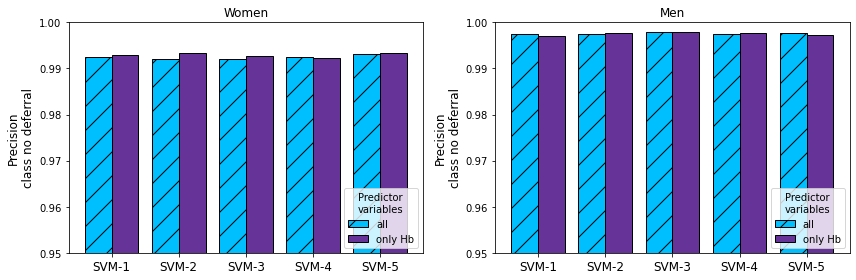

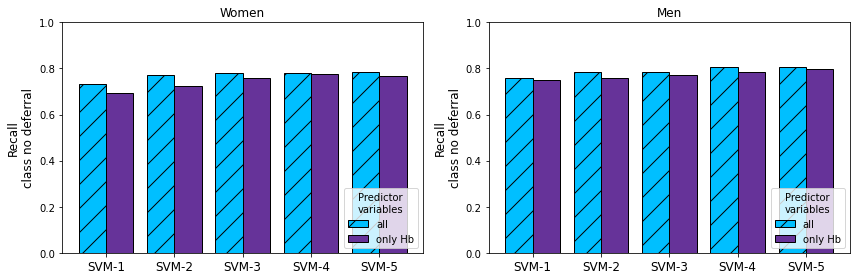

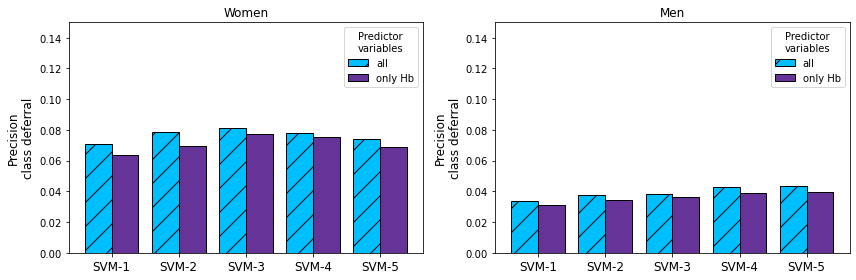

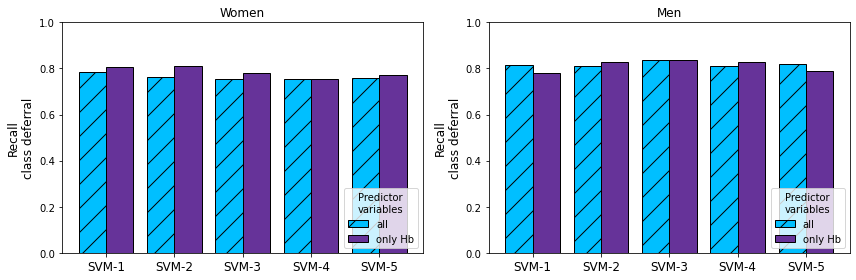

In [31]:
plot_precision_recall_comp(res_tot, 'ok_precision', (0.95, 1), 'Precision\nclass no deferral', save='compare_ok_precision')
plot_precision_recall_comp(res_tot, 'ok_recall', (0, 1), 'Recall\nclass no deferral', save='compare_ok_recall')
plot_precision_recall_comp(res_tot, 'low_precision', (0, 0.15), 'Precision\nclass deferral', save='compare_low_precision')
plot_precision_recall_comp(res_tot, 'low_recall', (0, 1), 'Recall\nclass deferral', save='compare_low_recall')

## Numerical comparison of performance measures
The diff column is calculated as (all vars) - (only Hb vars), so a positive difference indicates that the model with all variables performs better than the one with only Hb vars.

In [58]:
comp_res = res_tot.loc[res_tot['trainval'] == 'val', 
                       ['nback', 'sex', 
                        'ok_precision', 'ok_recall',
                        'low_precision', 'low_recall', 
                        'vars']].pivot(index=['nback', 'sex'], columns='vars')

comp_res['ok_precision', 'diff'] = comp_res['ok_precision', 'all'] - comp_res['ok_precision', 'onlyhb']
comp_res['ok_recall', 'diff'] = comp_res['ok_recall', 'all'] - comp_res['ok_recall', 'onlyhb']
comp_res['low_precision', 'diff'] = comp_res['low_precision', 'all'] - comp_res['low_precision', 'onlyhb']
comp_res['low_recall', 'diff'] = comp_res['low_precision', 'all'] - comp_res['low_precision', 'onlyhb']

comp_res

ok_precision           ok_recall           low_precision            \
vars               all    onlyhb       all    onlyhb           all    onlyhb   
nback sex                                                                      
1     F       0.992535  0.992870  0.732697  0.694599      0.070685  0.063920   
      M       0.997475  0.996946  0.760416  0.748178      0.034005  0.031041   
2     F       0.992108  0.993268  0.770882  0.722368      0.078743  0.069760   
      M       0.997511  0.997665  0.786045  0.758162      0.037605  0.034135   
3     F       0.991993  0.992672  0.781890  0.760764      0.081532  0.077351   
      M       0.997844  0.997809  0.782642  0.770272      0.038272  0.036286   
4     F       0.992391  0.992316  0.782464  0.774860      0.078046  0.075610   
      M       0.997557  0.997678  0.808159  0.784819      0.042785  0.038976   
5     F       0.993159  0.993330  0.785540  0.765521      0.073890  0.069012   
      M       0.997669  0.997239  0.807755  0.798479      0.043210  0.039825   

          low_recall           ok_precision ok_recall low_precision low_recall  
vars             all    onlyhb         diff      diff          diff       diff  
nback sex                                                                       
1     F     0.786765  0.806985    -0.000335  0.038098      0.006766   0.006766  
      M     0.814159  0.778761     0.000529  0.012238      0.002964   0.002964  
2     F     0.761538  0.809615    -0.001160  0.048514      0.008984   0.008984  
      M     0.809955  0.828054    -0.000154  0.027883      0.003470   0.003470  
3     F     0.754167  0.781250    -0.000679  0.021126      0.004180   0.004180  
      M     0.836449  0.836449     0.000035  0.012371      0.001986   0.001986  
4     F     0.754258  0.754258     0.000074  0.007604      0.002437   0.002437  
      M     0.812500  0.826923    -0.000121  0.023340      0.003809   0.003809  
5     F     0.759760  0.771772    -0.000171  0.020019      0.004878   0.004878  
      M     0.821429  0.790816     0.000430  0.009275      0.003385   0.003385

## Comparing precision-recall curves
Classifying observations in the test set again for the models using only Hb variables, now saving probability of deferral as determined by SVM in order to plot PR-curves. Baseline (deferral rate) is the same as for SVMs using all predictor variables.

In [ ]:
for nback in range(1,6):
    file_clf = '../results/models_onlyhb/clf_' + str(nback) + '.sav'
    clfs = pickle.load(open(file_clf, 'rb'))
    for index, sex in enumerate(['men', 'women']):
        #print(datetime.datetime.now(), 'Starting', nback, sex)
        clf = clfs[index]
        test = pd.read_pickle('../../data/scaled_onlyhb/'+str(sex)+'_'+str(nback)+'_test.pkl') 
        y_true = test[test.columns[-1:]].copy()
        y_pred = clf.predict_proba(test[test.columns[:-1]])
        y_true[['prob_low', 'prob_ok']] = y_pred
        file_preds = '../results/probas_onlyhb/proba_' + sex + '_' + str(nback) + '.pkl'
        pickle.dump(y_true, open(file_preds, 'wb'))

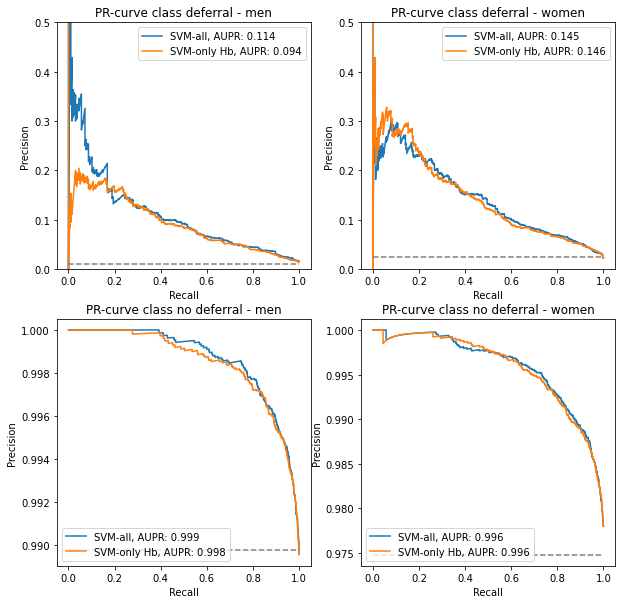

In [83]:
probas_onlyhb = load_probas(path='../results/probas_onlyhb/proba_')
probas['vars'] = 'all'
probas_onlyhb['vars'] = 'only Hb'

probas_all = pd.concat([probas, probas_onlyhb])
probas_5 = probas_all.loc[probas_all.nback == 5, ]

fig, ax = plt.subplots(2, 2, figsize=(10,10))

for x, sex in enumerate(['men', 'women']):
    df = probas_5.loc[probas_5['sex'] == sex, ]

    for key, group in df.groupby('vars'):
        precision_0, recall_0, thresholds_0 = precision_recall_curve(group.Hb_deferral, group.prob_low, pos_label=0)
        precision_1, recall_1, thresholds_1 = precision_recall_curve(group.Hb_deferral, group.prob_ok, pos_label=1)

        aupr_0 = round(average_precision_score(group.Hb_deferral, group.prob_low, pos_label=0), 3)
        aupr_1 = round(average_precision_score(group.Hb_deferral, group.prob_ok, pos_label=1), 3)

        ax[1,x].plot(recall_0, precision_0, label='SVM-'+str(key)+', AUPR: '+str(aupr_0))
        ax[0,x].plot(recall_1, precision_1, label='SVM-'+str(key)+', AUPR: '+str(aupr_1))

    ax[0,x].set_title('PR-curve class deferral - ' + ['men', 'women'][x])
    ax[0,x].set_xlabel('Recall')
    ax[0,x].set_ylabel('Precision')
    ax[1,x].set_title('PR-curve class no deferral - ' + ['men', 'women'][x])
    ax[1,x].set_xlabel('Recall')
    ax[1,x].set_ylabel('Precision')
    ax[0,x].legend(loc='upper right')
    ax[1,x].legend(loc='lower left')
    ax[0,x].set_ylim(0,0.5)

#horizontal lines for baseline
ax[0,0].hlines(y=def_m, xmin=0, xmax=1, color='grey', ls='--')
ax[1,0].hlines(y=1-def_m, xmin=0, xmax=1, color='grey', ls='--')
ax[0,1].hlines(y=def_f, xmin=0, xmax=1, color='grey', ls='--')
ax[1,1].hlines(y=1-def_f, xmin=0, xmax=1, color='grey', ls='--')

plt.savefig('../results/plots_performance/compare_PR_curve.png')

plt.show()